In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
import os

import jax
import jax.numpy as jnp
import numpy as np
from scipy import optimize

from vibrojet.basis_utils2 import ContrBasis, HermiteBasis, AssociateLegendreBasis, FourierBasis, generate_prod_ind 
from vibrojet.keo import Gmat, com
from vibrojet.potentials import h2co_AYTY
from vibrojet.taylor import deriv_list

jax.config.update("jax_enable_x64", True)

Equilibrium geometry

In [3]:
# vmin = optimize.minimize(h2co_AYTY.poten, [1, 1, 1, 2, 2, np.pi])
# r0 = vmin.x
# v0 = vmin.fun
# print("equilibrium coordinates:", r0)
# print("min of the potential:", v0)

r0 = np.array([1.20337419, 1.10377465, 1.10377465, 2.1265833,  2.1265833,  3.14159264])

Coordinate mapping

In [4]:
masses = [12.0, 15.99491463, 1.00782505, 1.00782505]  # masses of C, O, H, H

ncoo = len(r0)

# @eckart(r0, masses)
@com(masses)
def internal_to_cartesian(internal_coords):
    rCO, rCH1, rCH2, aOCH1, aOCH2, tau = internal_coords
    xyz = [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, rCO],
        [
            rCH1 * jnp.sin(aOCH1) * jnp.cos(tau * 0.5),
            -rCH1 * jnp.sin(aOCH1) * jnp.sin(tau * 0.5),
            rCH1 * jnp.cos(aOCH1),
        ],
        [
            rCH2 * jnp.sin(aOCH2) * jnp.cos(tau * 0.5),
            rCH2 * jnp.sin(aOCH2) * jnp.sin(tau * 0.5),
            rCH2 * jnp.cos(aOCH2),
        ],
    ]
    return jnp.array(xyz, dtype=jnp.float64)

Generate expansions for the KEO and PES

In [5]:
max_pow = 2
powers = [np.arange(max_pow + 1)] * ncoo
deriv_ind, deriv_mind = next(
    generate_prod_ind(powers, select=lambda ind: np.sum(ind) <= max_pow)
)

print("max expansion power:", max_pow)
print("number of expansion terms:", len(deriv_ind))

max expansion power: 2
number of expansion terms: 28


In [6]:
poten_file = f"_h2co_poten_coefs_{max_pow}.npy"
if os.path.exists(poten_file):
    print(f"load potential expansion coefs from file {poten_file}")
    poten_coefs = np.load(poten_file)
else:
    poten_coefs = deriv_list(h2co_AYTY.poten, deriv_ind, r0, if_taylor=True)
    np.save(poten_file, poten_coefs)

load potential expansion coefs from file _h2co_poten_coefs_2.npy


In [7]:
Gmat_file = f"_h2co_Gmat_coefs_{max_pow}.npy"
if os.path.exists(Gmat_file):
    print(f"load G-matrix expansion coefs from file {Gmat_file}")
    Gmat_coefs = np.load(Gmat_file)
else:
    Gmat_coefs = deriv_list(
        lambda x: Gmat(x, masses, internal_to_cartesian), deriv_ind, r0, if_taylor=True
    )
    np.save(Gmat_file, Gmat_coefs)

load G-matrix expansion coefs from file _h2co_Gmat_coefs_2.npy


Define linear mapping between coordinates of Hermite functions and internal valence coordinates

In [8]:
mask = deriv_ind != 0
ind0 = np.where(mask.sum(axis=1) == 0)[0][0]
mu = np.diag(Gmat_coefs[ind0])[:ncoo]

ind2 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (deriv_ind[:, icoo] == 2))[0][0]
        for icoo in range(ncoo)
    ]
)
freq = poten_coefs[ind2] * 2

lin_a = jnp.sqrt(jnp.sqrt(mu / freq))
lin_b = r0

list_herm = [0,1,2]
list_leg = [3,4]
list_fourier = [5]

lin_a = jnp.array([jnp.sqrt(jnp.sqrt(mu[i] / freq[i])) if i in list_herm
                    else np.pi/2 if i in list_leg
                    else 1.0
                    for i in range(ncoo)])

lin_b = jnp.array([r0[i] if i in list_herm
                    else np.pi/2 if i in list_leg
                    else 0.0
                    for i in range(ncoo)])

print("x->r linear mapping parameters 'a':", lin_a)
print("x->r linear mapping parameters 'b':", lin_b)

# x->r linear mapping function
x_to_r_map = lambda x, icoo: lin_a[icoo] * x + lin_b[icoo]
jac_x_to_r_map = lambda x, icoo: np.ones_like(x) * lin_a[icoo]

x->r linear mapping parameters 'a': [0.05234934 0.11034365 0.11034365 1.57079633 1.57079633 1.        ]
x->r linear mapping parameters 'b': [1.20337419 1.10377465 1.10377465 1.57079633 1.57079633 0.        ]


Define primitive basis

In [9]:
nbas = [80] * ncoo
npoints = [101] * ncoo

p0, p1, p2, p3, p4, p5 = [
    HermiteBasis(icoo, nbas[icoo], npoints[icoo], lambda x, icoo=icoo: x_to_r_map(x, icoo), r0[icoo], deriv_ind[:, icoo])
    if icoo in list_herm else
    AssociateLegendreBasis(icoo, nbas[icoo], npoints[icoo], lambda x, icoo=icoo: x_to_r_map(x, icoo), r0[icoo], deriv_ind[:, icoo])
    if icoo in list_leg else
    FourierBasis(icoo, nbas[icoo], npoints[icoo], lambda x, icoo=icoo: x_to_r_map(x, icoo), r0[icoo], deriv_ind[:, icoo])
    for icoo in range(ncoo)
]


Build contracted basis

In [10]:
sum_deriv_ind = np.sum(deriv_ind,axis=1)
poten_coefs_1d = lambda icoo: np.array([poten_coefs[i] if deriv_ind[i,icoo]==sum_deriv_ind[i] else 0.0 for i in range(len(sum_deriv_ind))])
Gmat_coefs_1d = lambda icoo: np.array([Gmat_coefs[i] if deriv_ind[i,icoo]==sum_deriv_ind[i] else np.zeros_like(Gmat_coefs[i]) for i in range(len(sum_deriv_ind))])

c0, c1, c2, c3, c4, c5 = [
    ContrBasis(
        (icoo,), (p0, p1, p2, p3, p4, p5), lambda _: True, Gmat_coefs_1d(icoo), poten_coefs_1d(icoo), store_int = True,
    )
    for icoo in range(ncoo)
]

Number of states: 80
batch no: 0  out of: 1
iteration time: 0.35
[  897.20155648  2691.60466944  4486.00778239  6280.41089535
  8074.81400831  9869.21712126 11663.62023422 13458.02334718
 15252.42646013 17046.82957309]
Saving integrals...
batch no: 0 out of: 1
iteration time: 0.01
Number of states: 80
batch no: 0  out of: 1
iteration time: 0.01
[ 1489.15561463  4467.4668439   7445.77807317 10424.08930244
 13402.4005317  16380.71176097 19359.02299024 22337.33421951
 25315.64544877 28293.95667804]
Saving integrals...
batch no: 0 out of: 1
iteration time: 0.01
Number of states: 80
batch no: 0  out of: 1
iteration time: 0.02
[ 1489.15561462  4467.46684385  7445.77807308 10424.08930231
 13402.40053154 16380.71176077 19359.02299    22337.33421924
 25315.64544847 28293.9566777 ]
Saving integrals...
batch no: 0 out of: 1
iteration time: 0.01
Number of states: 80
batch no: 0  out of: 1
iteration time: 0.02
[  745.0033813   2235.10462954  3723.27831173  5203.56358693
  6658.46519267  8075.741681

In [11]:
# couple CH1 and CH2
p_coefs = np.array([1, 1, 1, 1, 1, 1])

pmax = 50
c12 = ContrBasis(
    (1, 2),
    (c0, c1, c2, c3, c4, c5),
    lambda ind: np.sum(np.array(ind) * p_coefs[:len(ind)]) <= pmax,
    Gmat_coefs,
    poten_coefs,
    emax=30000,
    batch_size = 0, #0 = False (no batching)
)

e12 = c12.enr
print(e12[0], e12[0:5] - e12[0])

Number of states: 1326
batch no: 0  out of: 1
iteration time: 1.7
[ 4468.47942017  7418.37978964  7473.5556639  10368.28015911
 10423.45603338 10478.63190764 13318.18052859 13373.35640285
 13428.53227712 13483.70815138]
Saving integrals...
batch no: 0 out of: 1
iteration time: 0.86
4468.47942016568 [   0.         2949.90036947 3005.07624374 5899.80073895 5954.97661321]


In [12]:
# couple CH1 and CH2
p_coefs = np.array([1, 1, 1, 1, 1, 1])
pmax = 60
emax_trunc_ = 60000

e0,e1,e2,e3,e4,e5 = c0.enr,c1.enr,c2.enr,c3.enr,c4.enr,c5.enr
e_sum = [e0 - e0[0],e1 - e1[0],e2 - e2[0],e3 - e3[0],e4 - e4[0],e5 - e5[0],]
#Make energy truncation a part of basis generation for speed.
f_e_sum = lambda ind: np.sum(np.array([e_sum[i][ind[i]] for i in range(len(ind))])) < emax_trunc_
f_pmax = lambda ind: np.sum(np.array(ind) * p_coefs[:len(ind)]) <= pmax

c34 = ContrBasis(
    (3, 4),
    (c0, c1, c2, c3, c4, c5),
    f_e_sum or f_pmax,
    Gmat_coefs,
    poten_coefs,
    emax=30000,
    batch_size = 1000000,
    store_int = True,
)

e34 = c34.enr
print(e34[0], e34[0:5] - e34[0])

Number of states: 527
batch no: 0  out of: 1
iteration time: 0.6
[3692.82795753 4986.18197283 5316.33677593 6277.10492433 6607.70553264
 6938.65243051 7561.35295872 7889.00190163 8223.44468134 8558.82600335]
Saving integrals...
batch no: 0 out of: 1
iteration time: 0.17
3692.8279575311303 [   0.        1293.3540153 1623.5088184 2584.2769668 2914.8775751]


In [13]:
e0 = c0.enr
e5 = c5.enr

print('e0',e0[0], e0[0:5] - e0[0])
print('e12',e12[0], e12[0:5] - e12[0])
print('e34',e34[0], e34[0:5] - e34[0])
print('e5',e5[0], e5[0:5] - e5[0])

e0 897.2015564784987 [   0.         1794.40311296 3588.80622591 5383.20933887 7177.61245183]
e12 4468.47942016568 [   0.         2949.90036947 3005.07624374 5899.80073895 5954.97661321]
e34 3692.8279575311303 [   0.        1293.3540153 1623.5088184 2584.2769668 2914.8775751]
e5 590.8632332778204 [   0.         1183.61690754 2363.40652401 3539.35000868 4711.42820866]


In [14]:
# couple all together
p_coefs = np.array([1, 1, 1, 1])
pmax = 300
emax_trunc_ = 17000
e_sum = [e0 - e0[0],e12 - e12[0],e34 - e34[0],e5 - e5[0]]
#Make energy truncation a part of basis generation for speed.
f_e_sum = lambda ind: np.sum(np.array([e_sum[i][ind[i]] for i in range(len(ind))])) < emax_trunc_
f_pmax = lambda ind: np.sum(np.array(ind) * p_coefs[:len(ind)]) <= pmax
c = ContrBasis(
    (0, 1, 2, 3),
    (c0, c12, c34, c5),
    f_e_sum or f_pmax,
    Gmat_coefs,
    poten_coefs,
    store_int = False,
    emax_trunc=emax_trunc_,
    batch_size = 100000,
)
e = c.enr
print(e[0], e[0:20] - e[0])


Number of states before energy prune: 4815
Number of states after energy prune: 4815
batch no: 0  out of: 232
iteration time: 0.71
batch no: 1  out of: 232
iteration time: 0.7
batch no: 2  out of: 232
iteration time: 0.69
batch no: 3  out of: 232
iteration time: 0.7
batch no: 4  out of: 232
iteration time: 0.66
batch no: 5  out of: 232
iteration time: 0.7
batch no: 6  out of: 232
iteration time: 0.73
batch no: 7  out of: 232
iteration time: 0.68
batch no: 8  out of: 232
iteration time: 0.7
batch no: 9  out of: 232
iteration time: 0.67
batch no: 10  out of: 232
iteration time: 0.7
batch no: 11  out of: 232
iteration time: 0.69
batch no: 12  out of: 232
iteration time: 0.7
batch no: 13  out of: 232
iteration time: 0.7
batch no: 14  out of: 232
iteration time: 0.7
batch no: 15  out of: 232
iteration time: 0.68
batch no: 16  out of: 232
iteration time: 0.67
batch no: 17  out of: 232
iteration time: 0.69
batch no: 18  out of: 232
iteration time: 0.67
batch no: 19  out of: 232
iteration time

In [15]:
e_file = f"_h2co_Etrunc_{emax_trunc_}_pmax_{pmax}_{max_pow}.npy"
np.save(e_file, e[0:200])

In [17]:
# emax_trunc_0 = 17000
# emax_trunc_1 = 19000

# test0 = np.load(f"_h2co_Etrunc_{emax_trunc_0}_pmax_{pmax}_{max_pow}.npy")
# test1 = np.load(f"_h2co_Etrunc_{emax_trunc_1}_pmax_{200}_{max_pow}.npy")

# print(np.array(test1[0:100]) - np.array(test0[0:100]))

In [35]:
E_ref = np.array([5788.712271,  6955.974344,  7038.148724,  7288.866815,  7534.734317,
  8115.99898 ,  8211.595748,  8283.739593,  8455.5526  ,  8508.084151,
  8570.845311,  8632.024661,  8694.426677,  8787.732821,  8788.981466,
  9027.602632,  9260.356016,  9269.603444,  9374.632479,  9464.434895,
  9526.529401,  9614.081462,  9676.077504,  9725.363472,  9729.744488,
  9784.943314,  9811.337086,  9846.464283,  9872.595267,  9952.871946,
  9953.39938 ,  9981.941377, 10036.780696, 10044.682146, 10123.828855,
 10186.372998, 10255.81623 , 10284.044179, 10317.964166, 10360.28916,
 10412.325861, 10417.254152, 10518.492373, 10523.081827, 10529.853119,
 10629.665237, 10715.880743, 10745.327508, 10765.805928, 10767.687362,
 10830.418232, 10880.417442, 10898.095143, 10929.114106, 10942.859016,
 10966.113008, 10975.689783, 10993.033206, 11035.222247, 11045.145574,
 11101.638742, 11109.651533, 11114.227181, 11146.334595, 11174.883026,
 11203.760657, 11206.562681, 11221.287173, 11251.259185, 11278.181822,
 11279.696275, 11320.979953, 11332.823555, 11340.879455, 11414.65355,
 11439.76566 , 11448.357097, 11455.910879, 11469.420153, 11476.674856,
 11507.156782, 11520.299795, 11555.330013, 11557.075035, 11559.298749,
 11598.683103, 11611.341976, 11675.92871 , 11676.884147, 11678.090263,
 11725.309379, 11774.047297, 11776.368284, 11786.121697, 11787.393812,
 11842.011344, 11881.633816, 11896.007719, 11911.220985, 11967.429339,
 11975.522506])




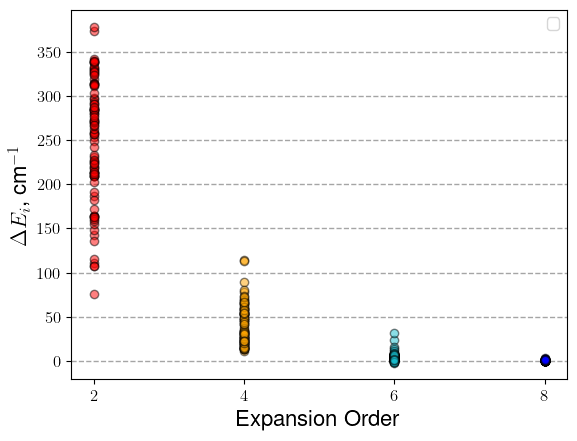

In [90]:
plt.rc('font', **{'family':'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('text', usetex=True)
label_size = 16
legend_size = 14
fig, ax = plt.subplots(1,1)

import matplotlib.pyplot as plt
emax_trunc_0 = 17000
Nstates = 100

#ax.grid(True, axis='y', linestyle='--', color='lightgray') 
ax.grid(which='major', axis='y', color=[0.3,0.3,0.3], alpha=0.5, linestyle='--', linewidth=1.0)

ax.set_axisbelow(True)

colors = ['b','tab:cyan','orange','r'][::-1]
for i in range(2,10,2):
    test = np.array(np.load(f"_h2co_Etrunc_{emax_trunc_0}_pmax_{pmax}_{i}.npy"))
    ax.scatter(i * np.ones_like(test[0:Nstates]),test[0:Nstates] - E_ref[0:Nstates], alpha=0.5, color=colors[int(i/2)-1], edgecolor='k')

#plt.yscale('log')
ax.legend(prop={'size': legend_size-3})
ax.set_xticks([2,4,6,8])
ax.set_ylabel('$\Delta E_i$, cm$^{-1}$', fontsize=label_size)
ax.set_xlabel('Expansion Order', fontsize=label_size)
ax.tick_params(axis='x', labelsize=label_size-4)
ax.tick_params(axis='y', labelsize=label_size-4)
plt.savefig('H2CO_TaylorOrder.pdf', format='pdf', dpi=600,bbox_inches='tight')
#ax.set_ylim([0,200])

In [88]:
test = np.array(np.load(f"_h2co_Etrunc_{emax_trunc_0}_pmax_{pmax}_{6}.npy"))
print(np.round(test[0:100] - E_ref[0:100],2))

[ 8.800e-01  8.800e-01  9.800e-01  1.040e+00  9.100e-01  5.700e-01
  8.900e-01  1.170e+00  1.040e+00  2.240e+00  6.770e+00  5.760e+00
  9.300e-01  1.350e+00  1.710e+00  1.160e+00  1.080e+00 -1.800e-01
  2.600e-01  9.800e-01  1.430e+00  6.600e-01  2.820e+00  3.230e+00
  7.520e+00  6.140e+00  7.300e+00  7.300e-01  5.160e+00  1.680e+00
  1.360e+00  3.400e+00  2.490e+00  7.540e+00  5.970e+00  1.220e+00
  3.040e+00  1.870e+00  6.770e+00  5.270e+00  1.160e+00 -1.430e+00
  1.690e+00  2.760e+00 -1.190e+00  8.000e-02  1.170e+00  1.670e+00
 -2.300e-01  1.780e+00  3.210e+00  7.990e+00  3.930e+00  6.140e+00
  4.220e+00  1.750e+00  8.070e+00  2.000e-02  5.550e+00  8.830e+00
  2.670e+00  1.100e+00  4.000e+00  4.290e+00  6.300e+00  4.970e+00
  6.040e+00  2.305e+01  3.188e+01  6.440e+00  6.390e+00  1.545e+01
  1.344e+01  6.220e+00  3.730e+00  1.073e+01  5.350e+00  4.860e+00
  7.640e+00  5.070e+00  5.840e+00  8.850e+00  8.200e-01  1.140e+00
  4.940e+00  6.460e+00  6.830e+00 -1.420e+00  1.070e+00  1.780

In [13]:
from typing import Callable, List

import jax
import jax.numpy as jnp
import numpy as np
from numpy.polynomial.hermite import hermder, hermgauss, hermval
from scipy.special import factorial
from itertools import product

import time

jax.config.update("jax_enable_x64", True)

class ContrBasis:
    def __init__(
        self,
        coupl_ind: List[int],
        bas_list,
        bas_select: Callable[[List[int]], bool],
        Gmat_coefs: np.ndarray,
        poten_coefs: np.ndarray,
        emax: float = 1e8,
        batch_size: int = 0,
        store_int = True,
    ):
        
        ind = [
            bas.bas_ind if ibas in coupl_ind else bas.bas_ind[0:1]
            for ibas, bas in enumerate(bas_list)
        ]
        ind, m_ind = next(generate_prod_ind(ind, select=bas_select))
        
        # basis indices for flattened matrix element arrays
        # i.e, if B = A[:, m_ind[ibas], m_ind[ibas]]
        #    then B.reshape(len(B), -1) = A.reshape(len(A), -1)[:, m_ind_flat[ibas]]
        m_ind_flat = []
        for m_i, bas in zip(m_ind, bas_list):
            i1, i2 = np.meshgrid(m_i, m_i, indexing="ij")
            flat_ind = i1 * len(bas.bas_ind) + i2
            m_ind_flat.append(flat_ind.reshape(-1))
            #   ... without numpy
            # n = len(bas.bas_ind)
            # flat_ind = [i * n + j for i in m_i for j in m_i]
            # m_ind_flat.append(flat_ind)

        coo_ind = [coo_ind for i in coupl_ind for coo_ind in bas_list[i].coo_ind]
        assert len(set(coo_ind)) == len(
            coo_ind
        ), "Input basis sets have overlapping coordinates"

        self.coo_ind = coo_ind
        nbas = len(ind)

        batch_size_ = nbas**2 if batch_size is 0 else batch_size
        n_batches = int(np.ceil(nbas**2 / batch_size_))

        vme = np.zeros(nbas**2)
        gme = np.zeros(nbas**2)
        for ibatch in range(n_batches):
            start_time = time.time()
            print('batch no:',ibatch,' out of:',int(np.ceil(nbas**2 / batch_size_)))
            index_batch = np.arange(ibatch * batch_size_, np.min([(ibatch+1) * batch_size_, nbas**2]))
            m_ind_flat_batch = []
            for z in range(len(m_ind_flat)):
                m_ind_flat_batch.append(m_ind_flat[z][index_batch])
            
            me = _me(
                [bas_list[i] for i in coupl_ind],
                [m_ind_flat_batch[i] for i in coupl_ind],
            )
    
            # define and solve reduced-mode eigenvalue problem
            # for basis sets that are involved in contraction
    
            # matrix elements of expansion terms for basis sets
            # that are not involved in contraction
            me0 = jnp.prod(
                jnp.asarray(
                    [
                        bas.me[ind]
                        for i, (bas, ind) in enumerate(zip(bas_list, m_ind_flat_batch))
                        if i not in coupl_ind
                    ]
                ),
                axis=0,
            )
    
            # potential matrix elements
            vme[index_batch] = (me * me0) @ poten_coefs
    
            # keo matrix elements
            # gme = 0
            # for icoo in self.coo_ind:
            #     for jcoo in self.coo_ind:
            #         gme += (d2me[(icoo, jcoo)] * me0) @ Gmat_coefs[:, icoo, jcoo]
            gme[index_batch] = compute_gme(bas_list, m_ind_flat_batch, coupl_ind, coo_ind, me0, Gmat_coefs)
            end_time = time.time()
            print('iteration time:',np.round(end_time-start_time,2))

        hme = -0.5 * gme + vme
        e, v = jnp.linalg.eigh(hme.reshape(nbas, nbas))
        print(e[0:10])
        v_ind = jnp.where(e - e[0] <= emax)[0]
        v = v[:, v_ind]
        self.enr = e[v_ind]
        
        # transform matrix elements to eigenbasis

        if store_int:    
            me_accum,dme_r_accum,dme_l_accum,d2me_accum = [],{},{},{}
        
            for ibatch in range(n_batches):
                print(f'batch no: {ibatch} out of: {n_batches}')
                index_batch = np.arange(
                    ibatch * batch_size_,
                    min((ibatch + 1) * batch_size_, nbas**2)
                )
        
                m_ind_flat_batch = [m[index_batch] for m in m_ind_flat]
        
                # Compute batch contributions
                me_batch = _me(
                    [bas_list[i] for i in coupl_ind],
                    [m_ind_flat_batch[i] for i in coupl_ind],
                )
                
                dme_r_batch = _dme_r(
                    [bas_list[i] for i in coupl_ind],
                    [m_ind_flat_batch[i] for i in coupl_ind],
                    coo_ind,
                )
                dme_l_batch = _dme_l(
                    [bas_list[i] for i in coupl_ind],
                    [m_ind_flat_batch[i] for i in coupl_ind],
                    coo_ind,
                )
                d2me_batch = _d2me(
                    [bas_list[i] for i in coupl_ind],
                    [m_ind_flat_batch[i] for i in coupl_ind],
                    coo_ind,
                )
        
                # Accumulate results
                me_accum.append(me_batch)
                for key, val in dme_r_batch.items():
                    dme_r_accum.setdefault(key, []).append(val)
                for key, val in dme_l_batch.items():
                    dme_l_accum.setdefault(key, []).append(val)
                for key, val in d2me_batch.items():
                    d2me_accum.setdefault(key, []).append(val)

            # Concatenate batches
            me = jnp.concatenate(me_accum, axis=0)  # or stack, depending on shape
            dme_r_full = {k: jnp.concatenate(v, axis=0) for k, v in dme_r_accum.items()}
            dme_l_full = {k: jnp.concatenate(v, axis=0) for k, v in dme_l_accum.items()}
            d2me_full = {k: jnp.concatenate(v, axis=0) for k, v in d2me_accum.items()}
        
            # Eigenbasis transform
            nstates = len(v_ind)
            self.bas_ind = np.arange(nstates)

            self.me = jnp.einsum(
                "pi,pqt,qj->ijt", v, me.reshape(nbas, nbas, -1), v
            ).reshape(nstates * nstates, -1)
        
            self.dme_r = {
                key: jnp.einsum(
                    "pi,pqt,qj->ijt", v, val.reshape(nbas, nbas, -1), v
                ).reshape(nstates * nstates, -1)
                for key, val in dme_r_full.items()
            }
            self.dme_l = {
                key: jnp.einsum(
                    "pi,pqt,qj->ijt", v, val.reshape(nbas, nbas, -1), v
                ).reshape(nstates * nstates, -1)
                for key, val in dme_l_full.items()
            }
            self.d2me = {
                key: jnp.einsum(
                    "pi,pqt,qj->ijt", v, val.reshape(nbas, nbas, -1), v
                ).reshape(nstates * nstates, -1)
                for key, val in d2me_full.items()
            }
            
def compute_gme(bas_list, m_ind_flat, coupl_ind, coo_ind, me0, Gmat_coefs):
    gme = 0
    for icoo in coo_ind:
        for jcoo in coo_ind:
            val_prod = None
            for i in coupl_ind:
                bas = bas_list[i]
                ind = m_ind_flat[i]
                if (icoo, jcoo) in bas.d2me:
                    val = bas.d2me[(icoo, jcoo)][ind]
                elif icoo in bas.coo_ind and jcoo in bas.coo_ind:
                    val = bas.dme_l[icoo][ind] * bas.dme_r[jcoo][ind]
                elif icoo in bas.coo_ind:
                    val = bas.dme_l[icoo][ind]
                elif jcoo in bas.coo_ind:
                    val = bas.dme_r[jcoo][ind]
                else:
                    val = bas.me[ind]
                val_prod = val if val_prod is None else val_prod * val
            gme += (val_prod * me0) @ Gmat_coefs[:, icoo, jcoo]
    return gme

def _me(coupl_bas, bas_m_ind):
    me = None
    for bas, ind in zip(coupl_bas, bas_m_ind):
        val = bas.me[ind]
        me = val if me is None else me * val
    return me

def _dme_l(coupl_bas, bas_m_ind, coo_ind):
    dme = {}
    for icoo in coo_ind:
        val_prod = None
        for bas, ind in zip(coupl_bas, bas_m_ind):
            if icoo in bas.coo_ind:
                val = bas.dme_l[icoo][ind]
            else:
                val = bas.me[ind]
            val_prod = val if val_prod is None else val_prod * val
        dme[icoo] = val_prod
    return dme

def _dme_r(coupl_bas, bas_m_ind, coo_ind):
    dme = {}
    for icoo in coo_ind:
        val_prod = None
        for bas, ind in zip(coupl_bas, bas_m_ind):
            if icoo in bas.coo_ind:
                val = bas.dme_r[icoo][ind]
            else:
                val = bas.me[ind]
            val_prod = val if val_prod is None else val_prod * val
        dme[icoo] = val_prod
    return dme


def _d2me(coupl_bas, bas_m_ind, coo_ind):
    d2me = {}
    for icoo in coo_ind:
        for jcoo in coo_ind:
            #for_bas = []
            val_prod = None
            for bas, ind in zip(coupl_bas, bas_m_ind):
                if (icoo, jcoo) in bas.d2me:
                    val = bas.d2me[(icoo, jcoo)][ind]
                elif icoo in bas.coo_ind and jcoo in bas.coo_ind:
                    val = bas.dme_l[icoo][ind] * bas.dme_r[jcoo][ind]
                elif icoo in bas.coo_ind:
                    val = bas.dme_l[icoo][ind]
                elif jcoo in bas.coo_ind:
                    val = bas.dme_r[jcoo][ind]
                else:
                    val = bas.me[ind]
                val_prod = val if val_prod is None else val_prod * val
            d2me[(icoo, jcoo)] = val_prod
    return d2me

def generate_prod_ind(
    indices: List[List[int]],
    select: Callable[[List[int]], bool] = lambda _: True,
    batch_size: int = None,
):
    
    no_elem = np.array([len(elem) for elem in indices])
    tot_size = np.prod(no_elem)
    list_ = indices[0]
    for i in range(1, len(indices)):
        list_ = list(product(list_,indices[i]))
        list_ = [tuple(a) + (b,) if isinstance(a, tuple) else (a, b) for a, b in list_]
        list_ = [elem for elem in list_ if select(elem)]
    yield np.array(list_), np.array(list_).T #indices_out, #multi_ind